# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [49]:
pip install palmerpenguins

In [50]:
# Code Here
# Code Here
from plotnine import *
import pandas as pd
import numpy as np
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.metrics import *
import palmerpenguins
from palmerpenguins import load_penguins
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, label_binarize
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


penguins = load_penguins()
penguins.head()
penguins = penguins.dropna()

#only dummified predictors
X = penguins.drop(columns=['species']); X = pd.get_dummies(X, drop_first=True)
Y = penguins['species']



Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [51]:
# Code Here
#kNN models
knn = Pipeline([
    ('standardize', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

#dt models
dt = Pipeline([
    ('standardize', StandardScaler()),
    ('tree', DecisionTreeClassifier(random_state=42))
])


param_grid_knn = {
    'knn__n_neighbors': [3,8]
}

param_grid_dt = {
    'tree__max_depth': [2,5]
}


knnCV = GridSearchCV(knn, param_grid = param_grid_knn, scoring='accuracy', return_train_score=True, n_jobs=-1)
dtCV  = GridSearchCV(dt, param_grid = param_grid_dt, scoring='accuracy', return_train_score=True, n_jobs=-1)

#Fit models
knnCV.fit(X, Y)
dtCV.fit(X, Y)

print("Best kNN parameters:", knnCV.best_params_)
print("Best Decision Tree parameters:", dtCV.best_params_)
print("Best kNN estimator:", knnCV.best_estimator_)
print("Best Decision Tree estimator:", dtCV.best_estimator_)

Best kNN parameters: {'knn__n_neighbors': 8}
Best Decision Tree parameters: {'tree__max_depth': 5}
Best kNN estimator: Pipeline(steps=[('standardize', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=8))])
Best Decision Tree estimator: Pipeline(steps=[('standardize', StandardScaler()),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])


In [52]:
knn_best = knnCV.best_estimator_
dt_best = dtCV.best_estimator_

knn_pred = cross_val_predict(knn_best, X, Y, cv=5)
dt_pred = cross_val_predict(dt_best, X, Y, cv=5)

#kNN confusion matrix
print("kNN Confusion Matrix")
print(confusion_matrix(Y, knn_pred))

#dt confusion matrix
print("dt Confusion Matrix")
print(confusion_matrix(Y, dt_pred))

#kNN classification matrix(has precision, recall, F1 scores)
print("kNN Classification Report")
print(classification_report(Y, knn_pred))

#dt classification matrix(has precision, recall, F1 scores)
print("dt Classification Report")
print(classification_report(Y, dt_pred))

#kNN accuracy score
print("kNN Accuracy Score")
print(accuracy_score(Y, knn_pred))

#dt accuracy score
print("dt Accuracy Score")
print(accuracy_score(Y, dt_pred))


#AUC Scores
classes = sorted(Y.unique())
Y_bins = label_binarize(Y, classes=classes)
knn_probs = knn_best.predict_proba(X)
dt_probs = dt_best.predict_proba(X)

print("AUC kNN")
print(roc_auc_score(Y_bins, knn_probs, multi_class='ovr'))#since technically binary and three options multi_class='ovr' makes it so it compares
#all 3 against one another

print("AUC Decision Tree")
print(roc_auc_score(Y_bins, dt_probs, multi_class='ovr'))




kNN Confusion Matrix
[[144   2   0]
 [  2  66   0]
 [  0   0 119]]
dt Confusion Matrix
[[142   3   1]
 [  2  66   0]
 [  1   0 118]]
kNN Classification Report
              precision    recall  f1-score   support

      Adelie       0.99      0.99      0.99       146
   Chinstrap       0.97      0.97      0.97        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333

dt Classification Report
              precision    recall  f1-score   support

      Adelie       0.98      0.97      0.98       146
   Chinstrap       0.96      0.97      0.96        68
      Gentoo       0.99      0.99      0.99       119

    accuracy                           0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333

kNN Accuracy Score
0.987987987987988
dt Accuracy Score

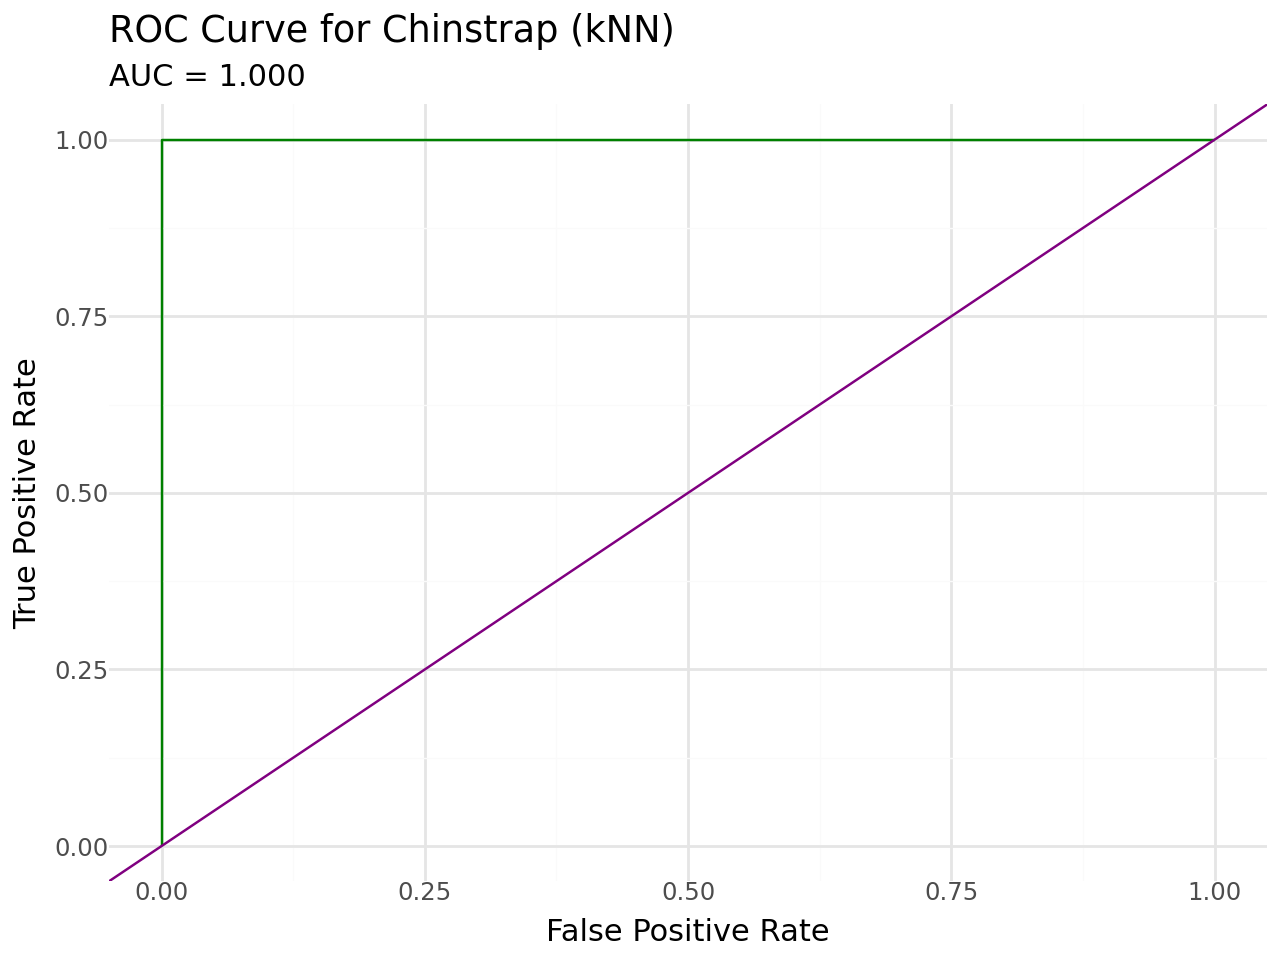

In [53]:
#ROC Curve for Chinstrap, needed GPT help for this


#class order, make into kind of binaries
classes = list(knn_best.classes_)
Y_bin = label_binarize(Y, classes=classes)

#Chinstrap species
i = classes.index("Chinstrap")

one, two, _ = roc_curve(Y_bin[:, i], knn_probs[:, i]) #I guess the _ is a place holder if I wanted to add threshold value or smthn?
curve_auc = auc(one, two)

#df for curve
roc_df = pd.DataFrame({"one": one, "two": two})

#ROC curve
(
    ggplot(roc_df, aes(x="one", y="two"))
    + geom_line(color="green")
    + geom_abline(intercept=0, slope=1, color="purple")
    + labs(
        title="ROC Curve for Chinstrap (kNN)",
        x="False Positive Rate",
        y="True Positive Rate",
        subtitle=f"AUC = {curve_auc:.3f}"
    )
    + theme_minimal()
)


#Im pretty sure my curve looks correct since my AUC scores were perfect, since classes were perfectly separable